## Background

## Setup
### Install dependencies

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

### Import dependencies

In [3]:
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

In [4]:
# import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
import tensorflow as tf

In [5]:
### Set GPU growth
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
'''

'\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\nfor gpu in gpus:\n    tf.config.experimental.set_memory_growth(gpu, True)\nfor gpu in gpus:\n    print("Name:", gpu.name, "  Type:", gpu.device_type)\n'

### Create folder setup

In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Make the directory if it doesn't exist
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

## Collect positives and anchor images
### Untar labelled faces in the wild dataset

In [7]:
!curl http://vis-www.cs.umass.edu/lfw/lfw.tgz -o lfw.tgz

^C


In [ ]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress tar gz labelled faces in the wild dataset
!tar -xvf lfw.tgz

In [ ]:
# Move LFW images to the following directory data/negative/
for directroy in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directroy)):
        EX_PATH = os.path.join('lfw', directroy, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collect positive and anchor classes

In [ ]:
# import uuid library to generate random names for the anchor images
import uuid

# Establish a connection to the webcam
cap =cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Cut down frame to 250x250
    frame = frame[120:120+250,200:200+250,:]
    
    #show image back to screen
    cv2.imshow("Collection", frame)
    
    # Collect anchor image
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Generate random name
        name = str(uuid.uuid4())
        # Save image
        cv2.imwrite(os.path.join(ANC_PATH, name + '.jpg'), frame)
        print('Anchor image saved')
    
    # Collect positive image
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Generate random name
        name = str(uuid.uuid4())
        # Save image
        cv2.imwrite(os.path.join(POS_PATH, name + '.jpg'), frame)
        print('Positive image saved')
        
    
    # Break if the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()

# Close all windows
cv2.destroyAllWindows()

###############################################################################
# Take almost 300 anchor images and take 300 positive images from each anchor
###############################################################################

In [ ]:
'''
frame
frame.shape
img = frame[120:120+250,200:200+250,::-1]
plt.imshow(img)
'''

## Load and preprocess images
### Get image paths

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [ ]:
# dir_test = anchor.as_numpy_iterator()
# print(next(dir_test))

### Preprocessing - Scale and Normalize

In [9]:
def preprocess(file_path):
    
    # Read the image file
    byte_image = tf.io.read_file(file_path)
    
    # Load the image
    img = tf.image.decode_jpeg(byte_image, channels=3)
    
    # Resize the image to 100x100
    img = tf.image.resize(img, [100, 100])
    
    # Normalize the image
    img = img / 255.0
    return img

In [10]:
# img = preprocess('data\\anchor\\f212266b-622c-40c0-a311-a493b4bef4ea.jpg')
# plt.imshow(img)

### Create labelled dataset

In [11]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(np.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(np.zeros(len(anchor)))))
dataset = positives.concatenate(negatives)

In [12]:
sample = dataset.as_numpy_iterator()
example =sample.next()
example

(b'data\\anchor\\6b86a5f0-4f07-4e49-ad16-32f78695332e.jpg',
 b'data\\positive\\827c7d63-de8d-48f9-bc25-bf97dd99470b.jpg',
 1.0)

### Train test split

In [13]:
def preprocess_twins(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [14]:
preprocess_twins(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.5517157 , 0.52892154, 0.47401962],
         [0.5178922 , 0.5154412 , 0.4627451 ],
         [0.4985294 , 0.5245098 , 0.45441177],
         ...,
         [0.35245097, 0.3156863 , 0.2512255 ],
         [0.36764705, 0.31911764, 0.264951  ],
         [0.36078432, 0.32254902, 0.2647059 ]],
 
        [[0.5448529 , 0.5183824 , 0.46348038],
         [0.5355392 , 0.514951  , 0.45906863],
         [0.5242647 , 0.51862746, 0.4509804 ],
         ...,
         [0.3622549 , 0.3245098 , 0.25367647],
         [0.34901962, 0.3019608 , 0.24509804],
         [0.3137255 , 0.29093137, 0.2379902 ]],
 
        [[0.5355392 , 0.5257353 , 0.45808825],
         [0.5230392 , 0.5122549 , 0.44754902],
         [0.5272059 , 0.51740193, 0.44387254],
         ...,
         [0.35563725, 0.32034314, 0.24877451],
         [0.3514706 , 0.3110294 , 0.26568627],
         [0.35955882, 0.3257353 , 0.29558823]],
 
        ...,
 
        [[0.5352941 , 0.53039217

In [43]:
# Build dataloarder pipeline
data = dataset.map(preprocess_twins)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [44]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
# train_data
# train_samples = train_data.as_numpy_iterator()
# train_exmp = train_samples.next()
# len(train_exmp[0])

## Model engineering
### Build embedding layer

In [18]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64,(10,10),activation='relu', name = 'conv_1')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same', name = 'pool_1' )(c1)
    
    # Second block
    c2 = Conv2D(128,(7,7),activation='relu', name = 'conv_2')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same', name = 'pool_2')(c2)
    
    # Third block
    c3 = Conv2D(128,(4,4),activation='relu', name = 'conv_3')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same', name = 'pool_3')(c3)
    
    # Final embedding block
    c4 = Conv2D(256,(4,4),activation='relu', name = 'conv_4')(m3)
    f1 = Flatten(name = 'flattern')(c4)
    d1 = Dense(4096, activation='relu', name = 'dense')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

### Build Distance Layer

In [19]:
class L1Distance(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Make Siamese Network

In [20]:
def make_siamese():
    
    # Anchor image in the network
    input_image = Input(name='input_image', shape=(100, 100, 3))
    
    # Validation image in the network
    validation_image = Input(name='validation_image', shape=(100, 100, 3))
    
    # Combine siamese distance component
    embeding = make_embedding()
    L1_distance = L1Distance()
    L1_distance._name = 'l1_distance'
    siamese_distance = L1_distance(embeding(input_image), embeding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid', name='classifier')(siamese_distance)
    
    return Model(inputs=[input_image, validation_image], outputs=[classifier], name='siamese')

In [21]:
model = make_siamese()
model.summary()

Model: "siamese"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_image (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_image[0][0]                
                                                                 validation_image[0][0]           
__________________________________________________________________________________________________
l1_distance (L1Distance)        (None, 4096)         0           embedding[0][0]            

## Training
### Setup loss function and optimizer

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

### Establish Checkpoint

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

### Build train step function

In [24]:
@tf.function
def train_step(batch,model):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    
    # Return loss
    return loss

### Build training loop

In [25]:
def train(data, epochs, model):
    # Loop through epochs
    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch,model)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [27]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, 3), (None, 100, 100, 3), (None,)), types: (tf.float32, tf.float32, tf.float64)>

### Train model

In [28]:
train(train_data, epochs=10, model=model)


 Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 831s 31s/step

 Epoch 2/10
27/27 [==============================] - 686s 25s/step

 Epoch 3/10
27/27 [==============================] - 690s 26s/step

 Epoch 4/10
27/27 [======================

## Evaluate model
### Import metrics

In [54]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make prediction

In [ ]:
# Get batch of test data
td = test_data.as_numpy_iterator()
test_input, test_val, y_true = td.next()

y_hat = model.predict([test_input,test_val])

In [55]:
[1 if y_hat>0.5 else 0 for y_hat in y_hat]

[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]

### Calculate metrics

In [56]:
# Creating a metric object
metric = Recall(name='recall')

# Calculate the metric value
metric.update_state(y_true, y_hat)

# Retrieve the metric value
metric.result().numpy()

1.0

In [57]:
# Creating a metric object
metric = Precision(name='precision')

# Calculate the metric value
metric.update_state(y_true, y_hat)

# Retrieve the metric value
metric.result().numpy()

1.0

### Visualize results

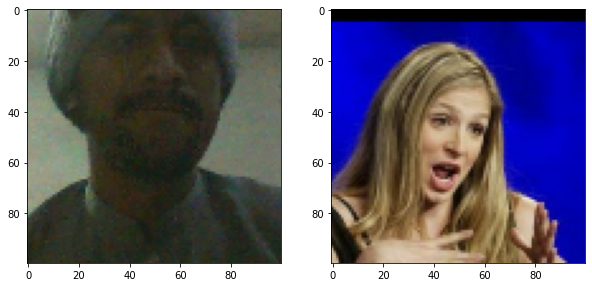

In [59]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

## Save model

In [68]:
# save weights
model.save('siamese_model.h5')

In [70]:
# Relod model
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Distance': L1Distance})

In [72]:
model.predict([test_input,test_val])

array([[9.2004931e-01],
       [2.9348235e-14],
       [9.9140141e-22],
       [2.8725998e-23],
       [9.9256217e-01],
       [9.9607193e-01],
       [9.9579829e-01],
       [3.8033096e-17],
       [9.9735820e-01],
       [4.8133941e-17],
       [1.5757378e-22],
       [4.1115289e-16],
       [4.2691218e-23],
       [8.5004658e-01],
       [3.7088603e-18],
       [3.2398464e-22]], dtype=float32)

## Real time test
### Varifcation function

In [77]:
INPUT_PATH = os.path.join('application_data', 'input_image')
VER_PATH = os.path.join('application_data', 'varification_images')

os.makedirs(INPUT_PATH , exist_ok=True)
os.makedirs(VER_PATH , exist_ok=True)

In [88]:
def verify(model, detection_threshold, verifcation_threshold):
    '''
    detection_threshold: float 
    verifcation_threshold: float
    '''
    
    # Build results array
    results =[]
    for image in os.listdir(VER_PATH):
        input_img = preprocess(os.path.join(INPUT_PATH,'input_image.jpg'))
        ver_img = preprocess(os.path.join(VER_PATH,image))
        
        # Make prediction
        result = model.predict(list(np.expand_dims([input_img, ver_img], axis=1)))
        results.append(result)
        
    # Detection Threshold : Metric above this value is considered as a match
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(VER_PATH))
    verified = verification > verifcation_threshold
    return results, verified

### OpenCV real time verification

In [90]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Verification',frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        # Save input image
        cv2.imwrite(os.path.join(INPUT_PATH,'input_image.jpg'),frame)
        
        # Verify
        results, verified = verify(model, detection_threshold=0.5, verifcation_threshold=0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
       break
   
cap.release()
cv2.destroyAllWindows()

True
True
False
False
True
False
False
